In [2]:
%matplotlib inline

import datacube
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import xarray as xr

import sys
sys.path.insert(1, '../Tools/')
from dea_tools.plotting import rgb
from dea_tools.plotting import rgb, display_map
from matplotlib import colors as mcolours

In [3]:
dc = datacube.Datacube(app='DEA_Land_Cover')

In [4]:
# Define area of interest and buffer values 
lat = -28.34223
lon = 137.31913
lat_buffer = 0.0003
lon_buffer = 0.0002

# Combine central coordinates with buffer to get area of intest 
lat_range = (lat - lat_buffer, lat + lat_buffer)
lon_range = (lon - lon_buffer, lon + lon_buffer)

# Set the range of dates for the analysis
time_range = ('2019', '2020')

In [5]:
display_map(x=lon_range, y=lat_range)

In [6]:
# Create the 'query' dictionary object, which contains the longitudes, latitudes and time defined above.
query = {
    'y': lat_range,
    'x': lon_range,
    'time': time_range,
}

# Load DEA Land Cover data from the datacube
lc = dc.load(product='ga_ls_landcover_class_cyear_2',
             output_crs='EPSG:3577',
             measurements=['level3'],
             resolution=(25, -25),
             **query)

In [7]:
# Plot layer from colour map
def plot_layer(colours, data):
    colour_arr = []
    cblabels = []
    for key, value in colours.items():
        colour_arr.append(np.array(value[:-2])/255)
        cblabels.append(value[-1])

    cmap = mcolours.ListedColormap(colour_arr)
    bounds = list(colours)
    bounds.append(255)
    norm = mcolours.BoundaryNorm(np.array(bounds) - 0.1, cmap.N)

    # plot the provided layer
    im = data.plot(cmap=cmap, norm=norm, add_colorbar=True, col='time', col_wrap=2, size=8)

    cb = im.cbar
    ticks = cb.get_ticks()
    cb.set_ticks(ticks + np.diff(ticks, append=256) / 2)
    cb.set_ticklabels(cblabels)    
    
    return im

In [8]:
# Define a colour scheme for the level3 layer
LEVEL3_COLOUR_SCHEME = { 0   : (255, 255, 255, 255, "No Data"),
                         111 : (172, 188, 45, 255, "Cultivated Terrestrial Vegetation"),
                         112 : (14, 121, 18, 255, "Natural Terrestrial Vegetation"),
                         124 : (30, 191, 121, 255, "Natural Aquatic Vegetation"),
                         215 : (218, 92, 105, 255, "Artificial Surface"),
                         216 : (243, 171, 105, 255, "Natural Bare Surface"),
                         220 : (77, 159, 220, 255, "Water")}

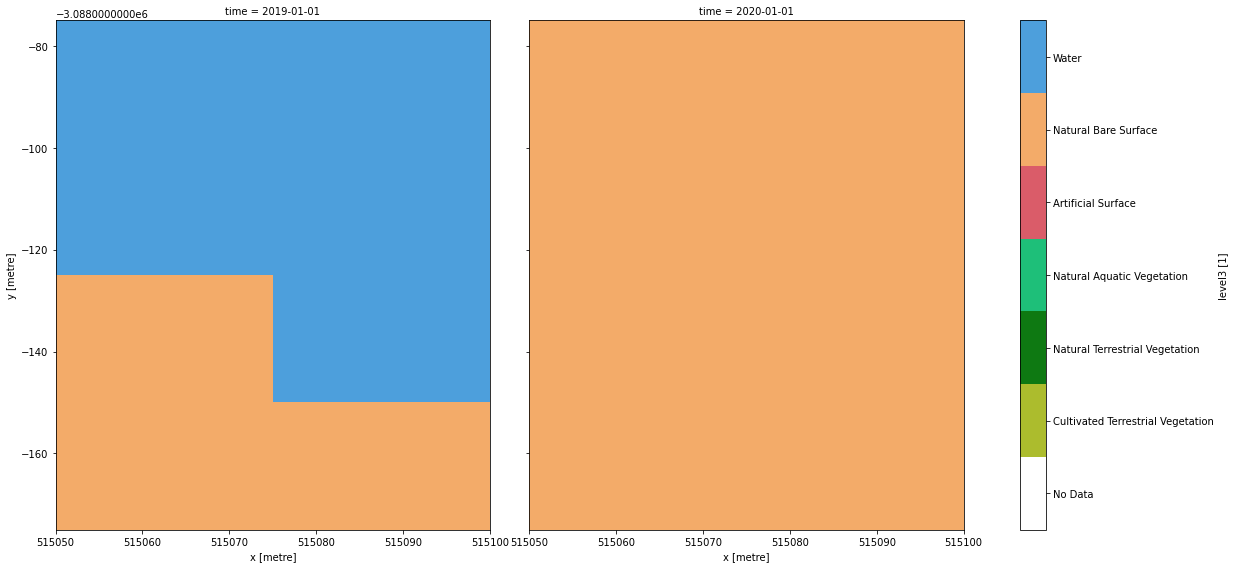

In [9]:
plot_layer(LEVEL3_COLOUR_SCHEME, lc.level3)

In [10]:
lc.level3

<xarray.DataArray 'level3' (time: 2, y: 4, x: 2)>
array([[[216, 216],
        [220, 216],
        [220, 220],
        [220, 220]],

       [[216, 216],
        [216, 216],
        [216, 216],
        [216, 216]]], dtype=uint8)
Coordinates:
  * time         (time) datetime64[ns] 2019-01-01 2020-01-01
  * y            (y) float64 -3.088e+06 -3.088e+06 -3.088e+06 -3.088e+06
  * x            (x) float64 5.151e+05 5.151e+05
    spatial_ref  int32 3577
Attributes:
    units:         1
    nodata:        0
    crs:           EPSG:3577
    grid_mapping:  spatial_ref

take both lists
take the first list in both lists
compare the ith element in each list 
    if water and water, add 0 to temp list
    if X to water, add 1 to temp list
    if water to X, add -1 to temp list
    go to next element in list 
    when done, add temp list to results list 

In [11]:
array1 = lc.level3[0]
array2 = lc.level3[1]

In [12]:
array1

<xarray.DataArray 'level3' (y: 4, x: 2)>
array([[216, 216],
       [220, 216],
       [220, 220],
       [220, 220]], dtype=uint8)
Coordinates:
    time         datetime64[ns] 2019-01-01
  * y            (y) float64 -3.088e+06 -3.088e+06 -3.088e+06 -3.088e+06
  * x            (x) float64 5.151e+05 5.151e+05
    spatial_ref  int32 3577
Attributes:
    units:         1
    nodata:        0
    crs:           EPSG:3577
    grid_mapping:  spatial_ref

In [13]:
array2

<xarray.DataArray 'level3' (y: 4, x: 2)>
array([[216, 216],
       [216, 216],
       [216, 216],
       [216, 216]], dtype=uint8)
Coordinates:
    time         datetime64[ns] 2020-01-01
  * y            (y) float64 -3.088e+06 -3.088e+06 -3.088e+06 -3.088e+06
  * x            (x) float64 5.151e+05 5.151e+05
    spatial_ref  int32 3577
Attributes:
    units:         1
    nodata:        0
    crs:           EPSG:3577
    grid_mapping:  spatial_ref

In [14]:
# water is 220
# bare is 216

def test_data(num1, num2):
    # water and water
    if num1 == num2:
        return 0
    # water to bare
    elif num1 == 220 and num2 != 220:
        return -1
    # bare to water 
    elif num1 != 220 and num2 == 220:
        return 1
    else:
        return 5

In [15]:
test_data(array1[0][0], array2[0][0])

0

In [16]:
array_len = len(array1)
array_len

4

In [17]:
list_len = len(array1[0])
list_len

2

In [22]:
change_mapping_results = []

i = 0

while i < array_len:
    year1 = array1[i]
    year2 = array2[i]
    
#     print("Current lists being compared", array1[i], array2[i])
#     print("---------------------------------------------------------")
        
    j = 0
    temp_change_value_list = []
    
    while j < list_len:
#         print("current value for array1", array1[i][j])
#         print("current value for array2", array2[i][j])
#         print("---------------------------------------------------------")

        temp_change_value = test_data(array1[i][j], array2[i][j])
        temp_change_value_list.append(temp_change_value)        

        j = j + 1
    
    print(temp_change_value_list)

    i = i + 1



[0, 0]
[-1, 0]
[-1, -1]
[-1, -1]


In [32]:
test_solution = np.array([[0, 0], [-1, 0], [-1, -1], [-1, -1]])

In [24]:
TEST_SCHEME = { 0  : (255, 255, 255, 255, "No change"),
                1  : (172, 188, 45, 255, "Bare to water"),
                -1 : (14, 121, 18, 255, "Water to bare"),
                5  : (30, 191, 121, 255, "N/A")}

In [33]:
array_x = array1

In [34]:
array_x.data = test_solution

In [38]:
array_x

<xarray.DataArray 'level3' (y: 4, x: 2)>
array([[ 0,  0],
       [-1,  0],
       [-1, -1],
       [-1, -1]])
Coordinates:
    time         datetime64[ns] 2019-01-01
  * y            (y) float64 -3.088e+06 -3.088e+06 -3.088e+06 -3.088e+06
  * x            (x) float64 5.151e+05 5.151e+05
    spatial_ref  int32 3577
Attributes:
    units:         1
    nodata:        0
    crs:           EPSG:3577
    grid_mapping:  spatial_ref